In [2]:
%run 'init.ipynb'
save = get_figsave(4)

In [3]:
x,y,V,alpha = sp.symbols('x,y,V,alpha')

alpha = x/V
C = 0.04695*alpha - 8.932e-4*alpha**3 + 1.015e-5*alpha**5 - 2.955e-8*alpha**7

xdot = -(-V**2 * C / 2 + x + 100*y)
ydot = x

F = sp.Matrix([xdot, ydot])
J = F.jacobian([x, y])

sp.solve(F)

In [35]:
2 / 0.04695

In [5]:
det = J.det()

In [6]:
tr = J.subs(x, 0).trace()

In [25]:
V_C = sp.solve(tr)

In [26]:
V_R = sp.solve(tr**2 - 4*det)[1]

In [15]:
# J.eigenvals()
# quick, but too long

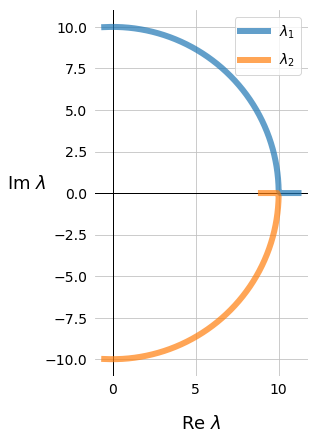

In [34]:
Vs = np.linspace(0+0j, 900+0j, 5000)
J_np = sp.lambdify(V, J.subs(dict(x=0, y=0)))
eigs = [np.linalg.eigvals(J_np(V)) for V in Vs]
lambda_1 = np.array([e[0] for e in eigs])
lambda_2 = np.array([e[1] for e in eigs])

fig, ax = plt.subplots(figsize=(6,6))
ax.axvline(color='black', lw=1)
ax.axhline(color='black', lw=1)
ax.plot(lambda_1.real, lambda_1.imag, '-', alpha=0.7, label='$\lambda_1$', lw=6)
ax.plot(lambda_2.real, lambda_2.imag, '-', alpha=0.7, label='$\lambda_2$', lw=6)
ax.set_xlabel(r'Re $\lambda$');
ax.set_ylabel(r'Im $\lambda$', rotation=0)
ax.set_aspect('equal')
ax.legend()
save(fig, 'eigencup')

/root/conda/envs/swr-detect/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: overflow encountered in double_scalars
  """
/root/conda/envs/swr-detect/lib/python3.6/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """


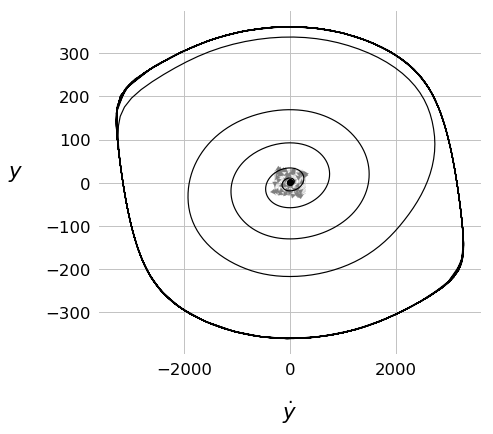

In [206]:
from scipy.spatial.distance import pdist, squareform
from scipy.integrate import solve_ivp


def get_grid(VV, scale):
    x_grid, y_grid =  np.meshgrid(np.linspace(scale*(-3), scale*(+3), 200),
                                  np.linspace(scale*(-0.3), scale*(+0.3), 200),
                                 )
    xdot_np = sp.lambdify((x,y), xdot.subs(V, VV))
    ydot_np = sp.lambdify((x,y), ydot.subs(V, VV))

    xdot_grid = xdot_np(x_grid, y_grid)
    ydot_grid = ydot_np(x_grid, y_grid)
    
    return x_grid, y_grid, xdot_grid, ydot_grid


def sim2(VV=0.4, x0=0.4, y0=0.02, fwd=True, t_span=(0.001,300), N_eval=1000):
    xdot_np = sp.lambdify((x,y), xdot.subs(V, VV))
    ydot_np = sp.lambdify((x,y), ydot.subs(V, VV))

    def f(t, y):
        return [xdot_np(y[0], y[1]), ydot_np(y[0], y[1])]

    t_span = np.array(t_span)
    # t_eval = np.linspace(*t_span, N_eval)
    t_eval = np.logspace(*np.log10(t_span), N_eval)
    if not fwd:
        t_span = -t_span
        t_eval = -t_eval
    t_span_arg = (t_eval[0], t_eval[-1])
    sol = solve_ivp(f, t_span_arg, [x0, y0], t_eval=t_eval)
    return sol.t, sol.y[0,:], sol.y[1,:]


def get_closed_orbit(VV, x0=0.05, y0=0.05, max_distance=0.0004, min_duration=4, N_eval=5000, t_span=(0.001,300)):
    t, xx, yy = sim2(VV, x0, y0, fwd=True, t_span=t_span, N_eval=N_eval)
    
    xy = np.stack([xx, yy], axis=1)
    tt = np.stack([t, t], axis=1)

    spatial_dist = pdist(xy)
    time_dist = pdist(tt)

    close_enough_in_space = spatial_dist < max_distance
    far_enough_in_time = time_dist > min_duration
    valid_ix_condensed = np.logical_and(close_enough_in_space, far_enough_in_time)
    num_valid = np.sum(valid_ix_condensed)
    if num_valid == 0:
        print(f'No trajectories found matching (max_dist={max_distance:.3g}, min_dur={min_duration:.3g})')

    valid_ix = np.nonzero(squareform(valid_ix_condensed))
    # selected_ix = num_valid//2
    selected_ix = -1
    ix_0 = valid_ix[0][selected_ix]
    ix_f = valid_ix[1][selected_ix]
    if ix_0 > ix_f:
        ix_0, ix_f = ix_f, ix_0

    period = t[ix_f] - t[ix_0]
    x_orbit = xx[ix_0:ix_f]
    y_orbit = yy[ix_0:ix_f]
    
    # Close circle
    x_orbit = np.concatenate([x_orbit, [x_orbit[0]]])
    y_orbit = np.concatenate([y_orbit, [y_orbit[0]]])
    
    return period, x_orbit, y_orbit


def plot_grid(VV, scale):
    grid = get_grid(VV, scale)
    fig, ax = streamplot(*grid, speed=False, lw_0=0.2, figsize=(6.2,5), equal=False, color='grey')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Limit cycle
    # period, x_orbit, y_orbit = get_closed_orbit(VV)
    # fig.text(0.94, 0.91, f'$T = {float(period):.0f}$', fontsize=24, color='purple', ha='right', va='top')
    # ax.plot(x_orbit, y_orbit, color=lc_color)
    
    # ax.set_xlim(-0.019, xlim[-1])
    # ax.set_ylim(-0.019, ylim[-1])
    ax.set_xlabel('$\dot{y}$')
    ax.set_ylabel('$y$', rotation=0, ha='right')
    # ax.set_title(f'$c = {float(VV):.6g}$', pad=11, fontsize=24)
    return fig, ax


def plot_traj(ax, VV, x0, y0):
    _, xx, yy = sim2(VV, x0, y0, fwd=True, t_span=(0.01, 10), N_eval=4000)
    ax.plot(x0, y0, '.', color='black')
    ax.plot(xx, yy, color='black', lw=1)


def phase_filename(VV):
    VV = float(VV)
    return f'phase_space_{VV:.4f}'.replace('.','')

V_C

VV = 200
scale = 100
fig, ax = plot_grid(VV=VV, scale=scale)
plot_traj(ax, VV, scale*0.01, scale*0.01)
# period, x_orbit, y_orbit = get_closed_orbit(VV, 0.6, 0.1)
# ax.plot(x_orbit, y_orbit, color='black', lw=1)
# print(period)
save(fig, 'bridge_phase')

## Brol

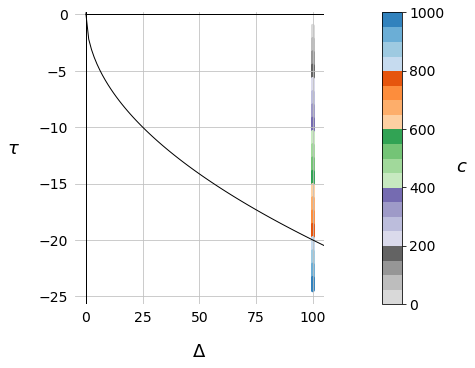

In [42]:
tr_np = sp.lambdify(V, tr)

Vs = np.linspace(0, 1000, 600)

fig, ax = plt.subplots(figsize=(7,5))
ax.axvline(color='black', lw=1)
scatter = ax.scatter(100*np.ones_like(Vs), tr_np(Vs), s=6, c=Vs, cmap=mpl.cm.tab20c_r)
cbar = fig.colorbar(scatter)
cbar.ax.set_ylabel('$c$', rotation=0)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.hlines(0, 0, 120, color='black', lw=1)
delta = np.linspace(0, 120, 100)
ax.plot(delta, +2*np.sqrt(delta), c='k', lw=1)
ax.plot(delta, -2*np.sqrt(delta), c='k', lw=1)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_ylim(-1.1, 0.4)
ax.set_xlabel(r'$\Delta$');
ax.set_ylabel(r'$\tau$', rotation=0, ha='right');
# ax.text(-0.046, -0.35, 'saddles', fontsize=14)
# ax.text(+0.01, -0.66, 'stable\nnodes', fontsize=14)
# ax.text(+0.06, -0.26, 'stable\nspirals', fontsize=14)
# ax.text(+0.06, +0.21, 'unstable\nspirals', fontsize=14)
# ax.text(+0.003, +0.31, 'u.n.', fontsize=14)
# save(fig, 'stability_diagram')